In [ ]:
import numpy as np 
import numpy.typing as npt 
import pandas as pd 

from tqdm.notebook import tqdm

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

from scipy.spatial import distance
from scipy.stats import mode

from math import sqrt, floor

from recognizer.misc import load_datasets
from recognizer.preprocessing import resample_dataset
from recognizer.cross_validation import user_independent_cross_validation, user_dependent_cross_validation, test_algo
from recognizer.plot import plot_sketch, plot_confusion_matrix, plot_multiple_confusion_matrix

from recognizer.knn import KNN
from recognizer.point_cloud import PointCloudRecognizer

### Load datasets

In [ ]:
X1, y1, hand_gesture_data_matrix1 = load_datasets(domain="Domain01")
X3, y3, hand_gesture_data_matrix3 = load_datasets(domain="Domain03")

### Dynamic Time Warping

In [ ]:
knn = KNN(n_neighbors=1, radius=1, metric="fast_dtw")

In [ ]:
dtw_accuracy_mean_d1_uindep, dtw_accuracy_std_d1_uindep, dtw_y_preds_d1_uindep, dtw_y_tests_d1_uindep = user_independent_cross_validation(
	estimator=knn, 
	X=resample_dataset(X1), 
	y=y1
)

In [ ]:
print("DOMAIN 01 - DYNAMIC TIME WARPING")

print("USER INDEPENDENT CROSS VALIDATION")
print(f"mean accuracy: {np.round(dtw_accuracy_mean_d1_uindep, 3)}")
print(f"std accuracy: {np.round(dtw_accuracy_std_d1_uindep, 3)}")

In [ ]:
plot_multiple_confusion_matrix(y_trues=dtw_y_tests_d1_uindep, y_preds=dtw_y_preds_d1_uindep)

In [ ]:
dtw_accuracy_mean_d1_udep, dtw_accuracy_std_d1_udep, dtw_y_preds_d1_udep, dtw_y_tests_d1_udep = user_dependent_cross_validation(
	estimator=knn, 
	X=resample_dataset(X1), 
	y=y1
)

In [ ]:
print("DOMAIN 01 - DYNAMIC TIME WARPING")

print("USER DEPENDENT CROSS VALIDATION")
print(f"mean accuracy: {np.round(dtw_accuracy_mean_d1_udep, 3)}")
print(f"std accuracy: {np.round(dtw_accuracy_std_d1_udep, 3)}")

In [ ]:
plot_multiple_confusion_matrix(y_trues=dtw_y_tests_d1_udep, y_preds=dtw_y_preds_d1_udep)

In [ ]:
dtw_accuracy_mean_d3_uindep, dtw_accuracy_std_d3_uindep, dtw_y_preds_d3_uindep, dtw_y_tests_d3_uindep = user_independent_cross_validation(
	estimator=knn, 
	X=resample_dataset(X3), 
	y=y3
)

In [ ]:
print("DOMAIN 03 - DYNAMIC TIME WARPING")

print("USER INDEPENDENT CROSS VALIDATION")
print(f"mean accuracy: {np.round(dtw_accuracy_mean_d3_uindep, 3)}")
print(f"std accuracy: {np.round(dtw_accuracy_std_d3_uindep, 3)}")

In [ ]:
plot_multiple_confusion_matrix(y_trues=dtw_y_tests_d3_uindep, y_preds=dtw_y_preds_d3_uindep)

In [ ]:
dtw_accuracy_mean_d3_udep, dtw_accuracy_std_d3_udep, dtw_y_preds_d3_udep, dtw_y_tests_d3_udep = user_dependent_cross_validation(
	estimator=knn, 
	X=resample_dataset(X3), 
	y=y3
)

In [ ]:
print("DOMAIN 03 - DYNAMIC TIME WARPING")

print("USER DEPENDENT CROSS VALIDATION")
print(f"mean accuracy: {np.round(dtw_accuracy_mean_d3_udep, 3)}")
print(f"std accuracy: {np.round(dtw_accuracy_std_d3_udep, 3)}")

In [ ]:
plot_multiple_confusion_matrix(y_trues=dtw_y_tests_d3_udep, y_preds=dtw_y_preds_d3_udep)

### $1 Recognizer

In [ ]:
recognizer = PointCloudRecognizer(N=32)
test_algo(recognizer, X1, y1)

In [4]:
recognizer = PointCloudRecognizer(N=32)

pcr_accuracy_mean_d1_uindep, pcr_accuracy_std_d1_uindep, pcr_y_preds_d1_uindep, pcr_y_tests_d1_uindep = user_independent_cross_validation(
	estimator=recognizer, 
	X=X1, 
	y=y1
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
print("DOMAIN 01 - $1 Recognizer")

print("USER INDEPENDENT CROSS VALIDATION")
print(f"mean accuracy: {np.round(pcr_accuracy_mean_d1_uindep, 3)}")
print(f"std accuracy: {np.round(pcr_accuracy_std_d1_uindep, 3)}")

DOMAIN 01 - $1 Recognizer
USER INDEPENDENT CROSS VALIDATION
mean accuracy: 0.925
std accuracy: 0.029


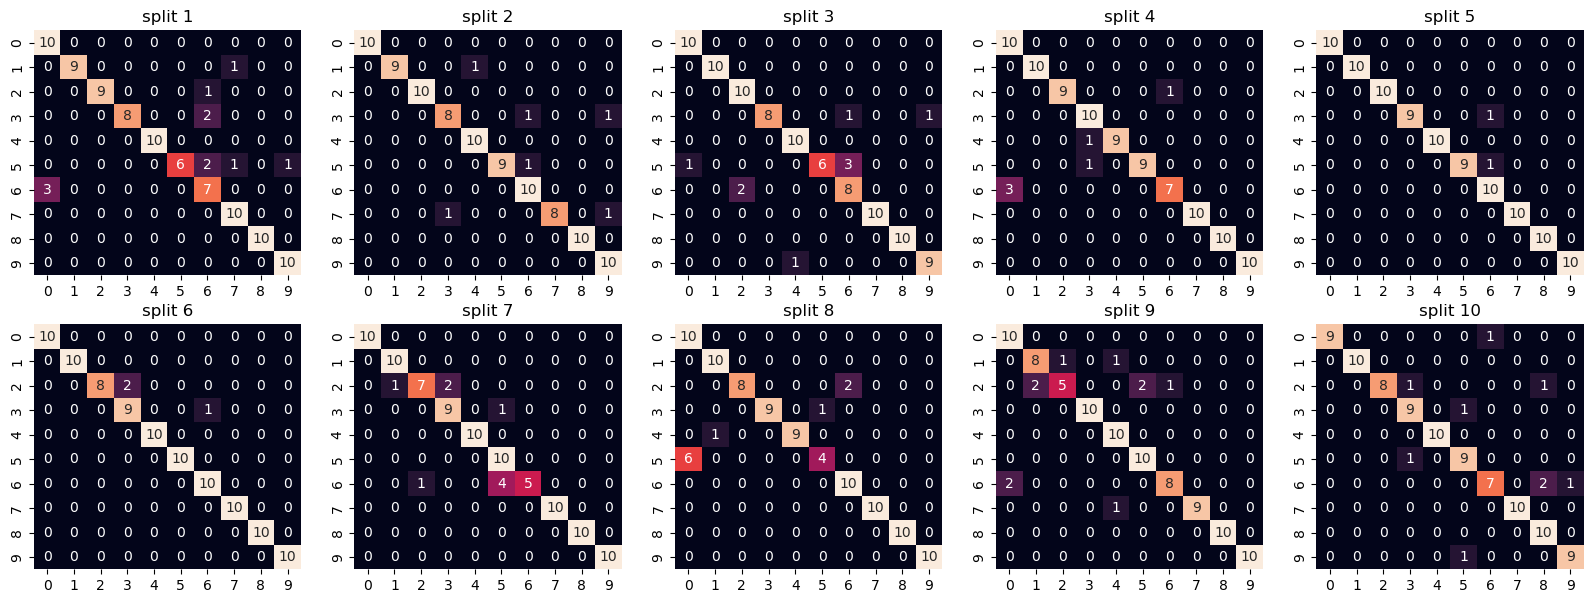

In [6]:
plot_multiple_confusion_matrix(y_trues=pcr_y_tests_d1_uindep, y_preds=pcr_y_preds_d1_uindep)

In [9]:
recognizer = PointCloudRecognizer(N=32)

pcr_accuracy_mean_d1_udep, pcr_accuracy_std_d1_udep, pcr_y_preds_d1_udep, pcr_y_tests_d1_udep = user_dependent_cross_validation(
	estimator=recognizer, 
	X=X1, 
	y=y1
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

DOMAIN 01 - $1 Recognizer
USER DEPENDENT CROSS VALIDATION
mean accuracy: 0.967
std accuracy: 0.02


In [10]:
print("DOMAIN 01 - $1 Recognizer")

print("USER DEPENDENT CROSS VALIDATION")
print(f"mean accuracy: {np.round(pcr_accuracy_mean_d1_udep, 3)}")
print(f"std accuracy: {np.round(pcr_accuracy_std_d1_udep, 3)}")

DOMAIN 01 - $1 Recognizer
USER DEPENDENT CROSS VALIDATION
mean accuracy: 0.967
std accuracy: 0.02


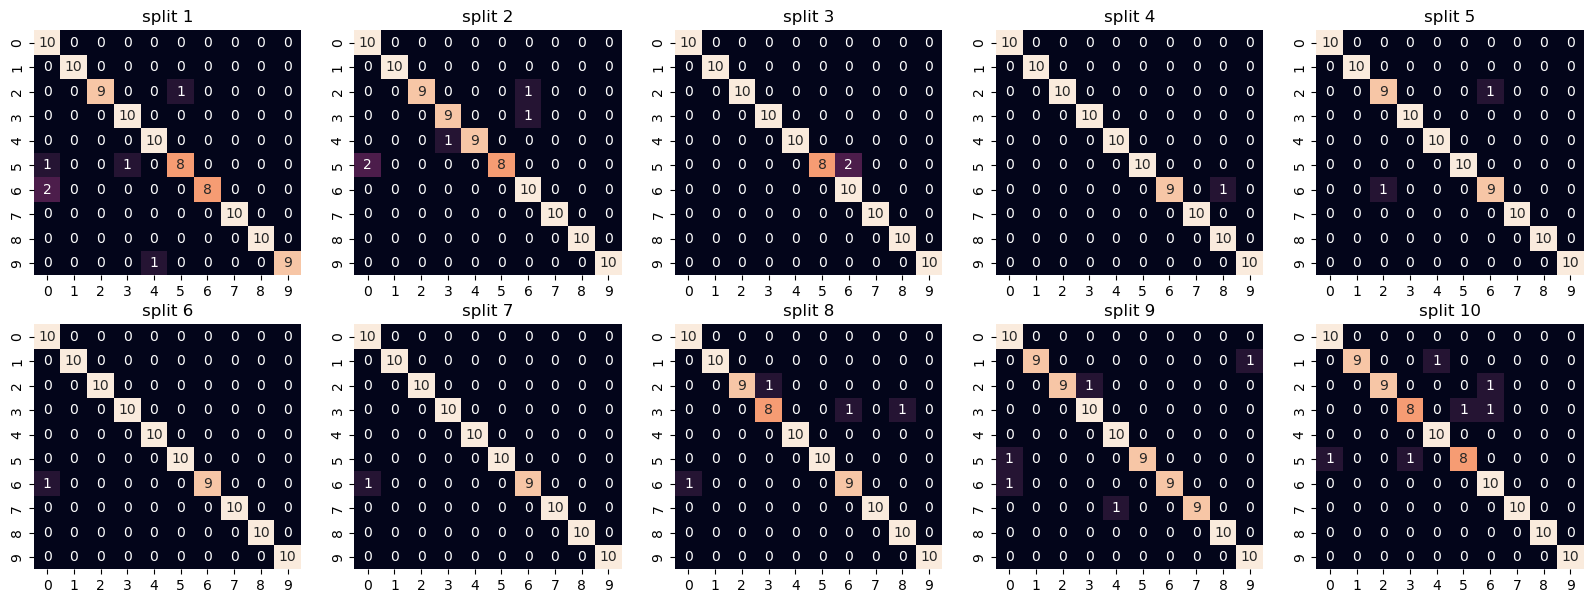

In [11]:
plot_multiple_confusion_matrix(y_trues=pcr_y_tests_d1_udep, y_preds=pcr_y_preds_d1_udep)

In [ ]:
recognizer = PointCloudRecognizer(N=32)

pcr_accuracy_mean_d3_uindep, pcr_accuracy_std_d3_uindep, pcr_y_preds_d3_uindep, pcr_y_tests_d3_uindep = user_independent_cross_validation(
	estimator=recognizer, 
	X=X3, 
	y=y3
)

print("DOMAIN 03 - $1 Recognizer")

print("USER INDEPENDENT CROSS VALIDATION")
print(f"mean accuracy: {np.round(pcr_accuracy_mean_d3_uindep, 3)}")
print(f"std accuracy: {np.round(pcr_accuracy_std_d3_uindep, 3)}")

In [ ]:
plot_multiple_confusion_matrix(y_trues=pcr_y_tests_d3_uindep, y_preds=pcr_y_preds_d3_uindep)

In [ ]:
recognizer = PointCloudRecognizer(N=32)

pcr_accuracy_mean_d3_udep, pcr_accuracy_std_d3_udep, pcr_y_preds_d3_udep, pcr_y_tests_d3_udep = user_dependent_cross_validation(
	estimator=recognizer, 
	X=X3, 
	y=y3
)

print("DOMAIN 03 - $1 Recognizer")

print("USER DEPENDENT CROSS VALIDATION")
print(f"mean accuracy: {np.round(pcr_accuracy_mean_d3_udep, 3)}")
print(f"std accuracy: {np.round(pcr_accuracy_std_d3_udep, 3)}")

In [ ]:
plot_multiple_confusion_matrix(y_trues=pcr_y_tests_d3_udep, y_preds=pcr_y_preds_d3_udep)